In [1]:
import pandas as pd
import re

# Pipeline to make votes prediction

## 1. First, let's import the necessary data

The data comes from [Dados Abertos da Camara](https://dadosabertos.camara.leg.br/swagger/api.html?tab=staticfile)

What is needed:

1. The dataset with the details of every voting session:

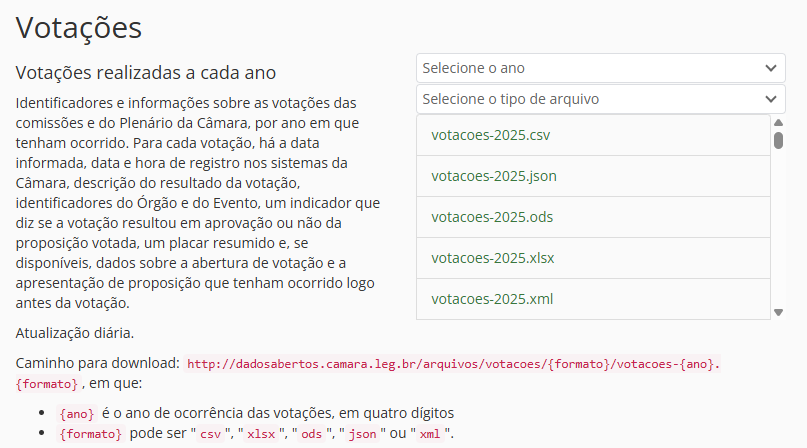

2. The dataset with the single votes from every deputy:

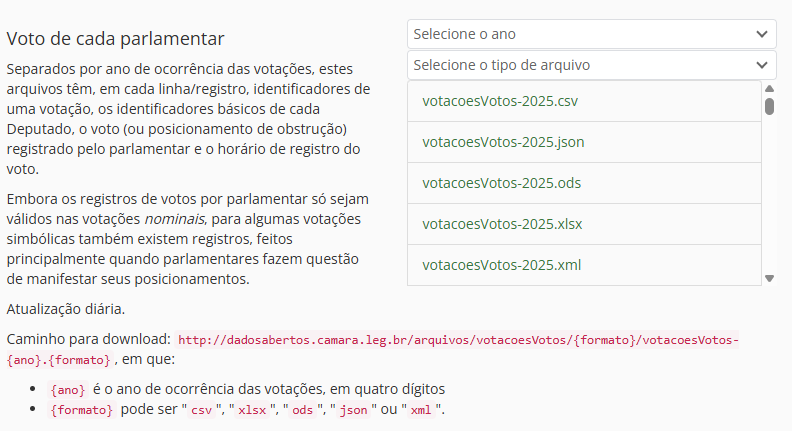

3. The dataset with propositions descriptions:

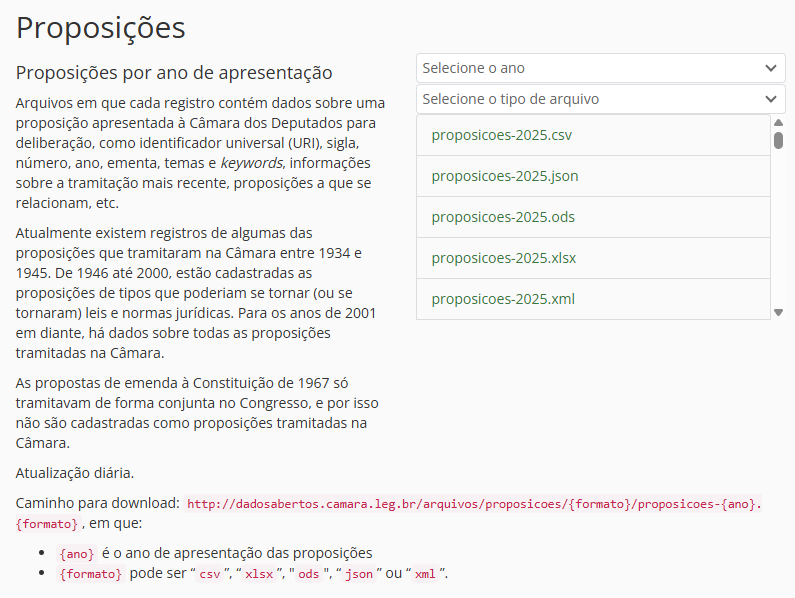




In [2]:
# Paths for voting sessions:

df_session_1 = "../data/voting/votacoes-2003.csv"

df_session_2 = "../data/voting/votacoes-2004.csv"

# df_session_3 and so on...

# ---------------------------------------------------------------

# Paths for single votes

df_votes_1 = "../data/voting/votes/votacoesVotos-2003.csv"

df_votes_2 = "../data/voting/votes/votacoesVotos-2004.csv"

# df_votes_3 and so on...

# --------------------------------------------------------------

# Paths for propositions

df_propositions_1 = "../data/propositions/proposicoes-2000.xlsx"

df_propositions_1 = "../data/propositions/proposicoes-2001.xlsx"

df_propositions_1 = "../data/propositions/proposicoes-2002.xlsx"

df_propositions_1 = "../data/propositions/proposicoes-2003.xlsx"

df_propositions_1 = "../data/propositions/proposicoes-2004.xlsx"

In [3]:
# Get all variables that match the pattern df_session_{number}
session_files = [value for key, value in globals().items() if key.startswith("df_session_")]

# Read all CSV files and concatenate into a single DataFrame
df_sessions = pd.concat([pd.read_csv(file, delimiter=';', quotechar='"') for file in session_files], ignore_index=True)

# Get all variables that match the pattern df_votes_{number}
votes_files = [value for key, value in globals().items() if key.startswith("df_votes_")]

# Read all CSV files and concatenate into a single DataFrame
df_votes = pd.concat([pd.read_csv(file, delimiter=';', quotechar='"') for file in votes_files], ignore_index=True)

# Get all variables that match the pattern df_propositions_{number}
propositions_files = [value for key, value in globals().items() if key.startswith("df_propositions_")]

# Read all CSV files and concatenate into a single DataFrame
df_propositions = pd.concat([pd.read_excel(file) for file in propositions_files], ignore_index=True)

e:\Anaconda\envs\dados_abertos\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 2. Data Processing

### 2.1 Filter only 'PLEN' organ

In [4]:
df_sessions['siglaOrgao'] = df_sessions['siglaOrgao'].astype(str).str.strip().str.upper()

df_sessions_PLEN = df_sessions[df_sessions['siglaOrgao'] == 'PLEN'].copy()

PLEN_IDs = df_sessions_PLEN['id'].unique()

df_votes_PLEN = df_votes[df_votes['idVotacao'].isin(PLEN_IDs)].copy()

### 2.2 Feature Selection

In [5]:
df_votes_PLEN

,idVotacao,uriVotacao,dataHoraVoto,voto,deputado_id,deputado_uri,deputado_nome,deputado_siglaPartido,deputado_uriPartido,deputado_siglaUf,deputado_idLegislatura,deputado_urlFoto
129,113716-111,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-08-06T00:27:12,Não,73764.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Abelardo Lupion,PFL,https://dadosabertos.camara.leg.br/api/v2/part...,PR,52,https://www.camara.leg.br/internet/deputado/ba...
130,113716-111,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-08-06T00:25:39,Sim,73886.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Adão Pretto,PT,https://dadosabertos.camara.leg.br/api/v2/part...,RS,52,https://www.camara.leg.br/internet/deputado/ba...
131,113716-111,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-08-06T00:25:08,Sim,74328.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Adauto Pereira,PFL,https://dadosabertos.camara.leg.br/api/v2/part...,PB,52,https://www.camara.leg.br/internet/deputado/ba...
132,113716-111,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-08-06T00:29:01,Sim,74386.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Adelor Vieira,PMDB,https://dadosabertos.camara.leg.br/api/v2/part...,SC,52,https://www.camara.leg.br/internet/deputado/ba...
133,113716-111,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-08-06T00:25:31,Sim,73765.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Affonso Camargo,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,PR,52,https://www.camara.leg.br/internet/deputado/ba...
...,...,...,...,...,...,...,...,...,...,...,...,...
37278,97884-75,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-05-26T18:49:56,Sim,74144.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Zelinda Novaes,PFL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,52,https://www.camara.leg.br/internet/deputado/ba...
37279,97884-75,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-05-26T18:51:53,Sim,74354.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Zenaldo Coutinho,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,PA,52,https://www.camara.leg.br/internet/deputado/ba...
37280,97884-75,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-05-26T19:03:08,Sim,73933.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Zequinha Marinho,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,PA,52,https://www.camara.leg.br/internet/deputado/ba...
37281,97884-75,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-05-26T18:49:56,Abstenção,73944.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Zico Bronzeado,PT,https://dadosabertos.camara.leg.br/api/v2/part...,AC,52,https://www.camara.leg.br/internet/deputado/ba...


In [6]:
df_FEATURES = df_votes_PLEN.drop(columns=['uriVotacao', 'dataHoraVoto', 'deputado_uri', 'deputado_nome', 'deputado_siglaPartido', 'deputado_uriPartido', 'deputado_siglaUf', 'deputado_idLegislatura', 'deputado_urlFoto'])
df_FEATURES

,idVotacao,voto,deputado_id
129,113716-111,Não,73764.0
130,113716-111,Sim,73886.0
131,113716-111,Sim,74328.0
132,113716-111,Sim,74386.0
133,113716-111,Sim,73765.0
...,...,...,...
37278,97884-75,Sim,74144.0
37279,97884-75,Sim,74354.0
37280,97884-75,Sim,73933.0
37281,97884-75,Abstenção,73944.0


In [7]:
df_sessions_PLEN

,id,uri,data,dataHoraRegistro,idOrgao,uriOrgao,siglaOrgao,idEvento,uriEvento,aprovacao,votosSim,votosNao,votosOutros,descricao,ultimaAberturaVotacao_dataHoraRegistro,ultimaAberturaVotacao_descricao,ultimaApresentacaoProposicao_dataHoraRegistro,ultimaApresentacaoProposicao_descricao,ultimaApresentacaoProposicao_idProposicao,ultimaApresentacaoProposicao_uriProposicao
1,96076-49,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,NaN,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,3282,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovada a Redação Final oferecida pelo Relato...,NaN,Votação da Redação Final.,NaN,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",104848,https://dadosabertos.camara.leg.br/api/v2/prop...
2,98922-29,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,NaN,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,3282,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovada a Redação Final oferecida pelo Relato...,NaN,Votação da Redação Final,NaN,"Parecer Proferido em Plenário, Dep. Ronaldo Ca...",104779,https://dadosabertos.camara.leg.br/api/v2/prop...
3,102277-6,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,NaN,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,0,NaN,1,0,0,0,Aprovado requerimento n. 264/2002 de Líderes q...,NaN,NaN,2011-01-20T16:13:25,Apresentação do Requerimento pelo Deputado Wal...,104615,https://dadosabertos.camara.leg.br/api/v2/prop...
4,103255-3,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,NaN,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,3282,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovado o Requerimento,NaN,NaN,NaN,Apresentação da Urgência (Art. 155 do RICD) pe...,0,NaN
5,96076-46,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,NaN,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,3282,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovado o Substitutivo oferecido pelo Relator...,NaN,Votação em turno único.,NaN,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",104848,https://dadosabertos.camara.leg.br/api/v2/prop...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16906,265618-84,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-12-22,2004-12-22T18:36:37,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,8389,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovada a Emenda de Redação oferecida pelo Re...,2004-12-22T18:35:41,Votação da Redação Final.,2004-12-22T18:29:31,"Parecer proferido em Plenário pelo Relator, De...",274333,https://dadosabertos.camara.leg.br/api/v2/prop...
16907,264768-26,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-12-22,2004-12-22T18:58:00,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,8389,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovado este Projeto.,2004-12-22T18:56:36,Votação em turno único.,2005-05-31T20:44:13,Apresentação da Requerimento de Urgência (Art....,274335,https://dadosabertos.camara.leg.br/api/v2/prop...
16908,264768-28,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-12-22,2004-12-22T18:58:33,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,8389,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,Aprovada a Redação Final oferecida pelo Relator.,2004-12-22T18:58:10,Votação da Redação Final.,2005-05-31T20:44:13,Apresentação da Requerimento de Urgência (Art....,274335,https://dadosabertos.camara.leg.br/api/v2/prop...
16909,144047-130,https://dadosabertos.camara.leg.br/api/v2/vota...,2004-12-22,2004-12-22T20:51:40,180,https://dadosabertos.camara.leg.br/api/v2/orga...,PLEN,8390,https://dadosabertos.camara.leg.br/api/v2/even...,1,0,0,0,"Aprovado o Substitutivo do Senado Federal, com...",2004-12-22T20:24:31,Votação em turno único. (Sessão Extraordinária...,2004-03-17T21:15:06,"Parecer proferido em Plenário pelo Relator, De...",156788,https://dadosabertos.camara.leg.br/

In [8]:
def parse_emenda(text: str):
    """
    Checks if the text contains the word 'emenda' (case-insensitive).
    If yes, tries to find a number right after it using a regex.
    Returns (type, number):
        - ("Emenda", <num>) if 'emenda' is found and there's a number
        - ("Emenda", None) if 'emenda' is found but no number is found
        - (None, None) otherwise (if 'emenda' is not found)
    """
    text_lower = str(text).lower()
    if "emenda" in text_lower:
        pattern = re.compile(r'(?i)emenda.*?(\d+)')
        match = pattern.search(text_lower)
        if match:
            return "Emenda", match.group(1)
        else:
            return "Emenda", None
    return None, None

def extract_emenda_info(row):
    """
    1) Check if row['descricao'] contains 'emenda'.
    2) If it doesn't contain 'emenda', return (None, None).
    3) If it does contain 'emenda', attempt to find the number in 'descricao'.
    4) If no number is found in 'descricao', attempt to find it in 
       'ultimaApresentacaoProposicao_descricao'.
    """
    # Step 1 & 2: parse 'descricao' first
    t_desc, num_desc = parse_emenda(row['descricao'])
    
    # If there's no 'emenda' in 'descricao', we stop here
    if t_desc is None:
        return None, None
    
    # If we found a number in 'descricao', return it
    if num_desc is not None:
        return t_desc, num_desc
    
    # If 'emenda' was found but no number in 'descricao', 
    # check 'ultimaApresentacaoProposicao_descricao'
    _, num_ultima = parse_emenda(row['ultimaApresentacaoProposicao_descricao'])
    
    # We already know it's "Emenda" (from descricao), so just pass it along
    return "Emenda", num_ultima

In [17]:
# Create the new dataframe with the desired columns
df_sessions_selected = df_sessions_PLEN[['id', 'descricao', 'ultimaApresentacaoProposicao_idProposicao', 'ultimaApresentacaoProposicao_descricao']].copy()

# Apply the function to each row
df_sessions_selected['Type'], df_sessions_selected['E_Number'] = zip(
    *df_sessions_selected.apply(extract_emenda_info, axis=1)
)

In [18]:
df_sessions_selected

,id,descricao,ultimaApresentacaoProposicao_idProposicao,ultimaApresentacaoProposicao_descricao,Type,E_Number
1,96076-49,Aprovada a Redação Final oferecida pelo Relato...,104848,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",None,None
2,98922-29,Aprovada a Redação Final oferecida pelo Relato...,104779,"Parecer Proferido em Plenário, Dep. Ronaldo Ca...",None,None
3,102277-6,Aprovado requerimento n. 264/2002 de Líderes q...,104615,Apresentação do Requerimento pelo Deputado Wal...,None,None
4,103255-3,Aprovado o Requerimento,0,Apresentação da Urgência (Art. 155 do RICD) pe...,None,None
5,96076-46,Aprovado o Substitutivo oferecido pelo Relator...,104848,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",None,None
...,...,...,...,...,...,...
16906,265618-84,Aprovada a Emenda de Redação oferecida pelo Re...,274333,"Parecer proferido em Plenário pelo Relator, De...",Emenda,None
16907,264768-26,Aprovado este Projeto.,274335,Apresentação da Requerimento de Urgência (Art....,None,None
16908,264768-28,Aprovada a Redação Final oferecida pelo Relator.,274335,Apresentação da Requerimento de Urgência (Art....,None,None
16909,144047-130,"Aprovado o Substitutivo do Senado Federal, com...",156788,"Parecer proferido em Plenário pelo Relator, De...",None,None


In [11]:
df_sessions_selected[df_sessions_selected['Type'] == 'Emenda']

,id,descricao,ultimaApresentacaoProposicao_descricao,Type,E_Number
207,102569-61,"Aprovada a Emenda de Redação de Srs. Líderes, ...","Leitura do Parecer pelo Relator, Dep. Gervásio...",Emenda,11
372,18480-58,Aprovado o Requerimento do Sr. Dep. Henrique F...,NaN,Emenda,6
373,18480-61,"Aprovada a Emenda Substitutiva Global nº 6, co...",NaN,Emenda,6
374,18480-62,Aprovada a Subemenda do Relator.,NaN,Emenda,None
589,31767-67,"Aprovadas as Emendas de Plenário de nºs. 7, 1...","Parecer Proferido em Plenário, Dep. Ibrahim Ab...",Emenda,7
...,...,...,...,...,...
16902,264286-85,Aprovadas as Emendas do Senado Federal de nºs ...,"Parecer proferido em Plenário pelo Relator, De...",Emenda,1
16903,264286-86,Rejeitadas as Emendas do Senado Federal de nºs...,"Parecer proferido em Plenário pelo Relator, De...",Emenda,2
16904,265543-87,"Rejeitada a Emenda do Senado Federal, com pare...","Parecer proferido em Plenário pelo Relator, De...",Emenda,None
16905,265618-81,"Aprovada a Emenda do Senado Federal, com parec...","Parecer proferido em Plenário pelo Relator, De...",Emenda,None


### 2.3 Define Train and Test Dataset

We need to know:

1. The number of unique and valid deputies
2. All the valid votes
3. All the valid voting sessions

Let's also organize some important info for metadata like:

1. Deputy name
2. Party name
3. Federal Unity Acronym

In [12]:
# Dataset with unique deputies and their metadata

unique_column = 'deputado_id'

metadata_columns = ['deputado_nome', 'deputado_siglaPartido', 'deputado_siglaUf']

df_deputies = df_votes.drop_duplicates(subset=[unique_column])[[unique_column] + metadata_columns]

df_deputies.head()

,deputado_id,deputado_nome,deputado_siglaPartido,deputado_siglaUf
0,73928.0,Ann Pontes,PMDB,PA
1,73434.0,Arnaldo Faria de Sá,PTB,SP
2,74263.0,Cláudio Magrão,PPS,SP
3,74060.0,Daniel Almeida,PCdoB,BA
4,74381.0,Dra. Clair,PT,PR


## 3. Modularity Optimization Loop

### 3.1 Calculate the 'yes' votes percentage for every voting session

- With this data we will calculate the percentage of yes votes for every unique voting session

In [13]:
# Unique voting sessions with their number of yes votes, total votes and % of yes votes

total_votes = df_votes.groupby('idVotacao').size().reset_index(name='total_votes')

yes_votes = df_votes[df_votes['voto'] == 'Sim'].groupby('idVotacao').size().reset_index(name='yes_votes')

df_voting_sessions = total_votes.merge(yes_votes, on='idVotacao', how='left')

df_voting_sessions['yes_votes'] = df_voting_sessions['yes_votes'].fillna(0).astype(int)

df_voting_sessions['yes_percentage'] = (df_voting_sessions['yes_votes'] / df_voting_sessions['total_votes']) * 100

df_voting_sessions.head()

,idVotacao,total_votes,yes_votes,yes_percentage
0,104509-28,13,8,61.538462
1,104964-30,32,18,56.250000
2,105060-40,6,6,100.000000
3,105467-26,28,26,92.857143
4,108139-30,13,8,61.538462


In [14]:
filtered_voting_sessions = []

for lower in range(0, 50, 5):  
    upper = 100 - lower  
    df_filtered = df_voting_sessions[
        (df_voting_sessions['yes_percentage'] >= lower) &
        (df_voting_sessions['yes_percentage'] <= upper)
    ]
    
    
    filtered_voting_sessions.append((lower, upper, df_filtered))

    print(f"Intervalo {lower}% - {upper}%")
    print(df_filtered)
    print("-" * 50)

Intervalo 0% - 100%
     idVotacao  total_votes  yes_votes  yes_percentage
0    104509-28           13          8       61.538462
1    104964-30           32         18       56.250000
2    105060-40            6          6      100.000000
3    105467-26           28         26       92.857143
4    108139-30           13          8       61.538462
..         ...          ...        ...             ...
153   43733-12          360        356       98.888889
154   63924-21           20         15       75.000000
155   97884-50          356        345       96.910112
156   97884-59          376        347       92.287234
157   97884-75          393        365       92.875318

[158 rows x 4 columns]
--------------------------------------------------
Intervalo 5% - 95%
     idVotacao  total_votes  yes_votes  yes_percentage
0    104509-28           13          8       61.538462
1    104964-30           32         18       56.250000
3    105467-26           28         26       92.857143
4    1